In [1]:
import torch
import torch.nn as nn
import torch.utils.data
from torch import nn, optim, distributions
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, TensorDataset, DataLoader
%matplotlib inline

from collections import deque
import numpy as np
from scipy.stats import mode

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

MNIST_train = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
                   batch_size=128, shuffle=True)

MNIST_test = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True,
                   transform=transforms.ToTensor()),
                   batch_size=128, shuffle=True)

In [3]:
def plot_image(tensor, label=None):
    '''Takes a [n, n] tensor, transform it to numpy and plot gray scale'''
    tensor = tensor.cpu().numpy()
    plt.imshow(tensor, cmap='gray', vmin=0, vmax=1)
    if label is not None:
        print('The correct label is {}'.format(label))

# Success Unit

The following block works well for MNIST. It use binary cross entropy loss. It also records the loss that is used in the following unit, which is $\log p_\theta(x|z)$ if $x=sigmoid(y)$ with $y\sim\mathcal{N}(\mu_\theta(z),\sigma_\theta(z))$.

In [4]:
class encoder(nn.Module):
    '''this encoder is the recognition model'''
    def __init__(self, input_dim, code_dim, hidden=None):
        super(encoder, self).__init__()
        if hidden is None:
            hidden = [256, 256]
        
        #For new mean
        self.fc1_1 = nn.Linear(input_dim, hidden[0])
        self.fc1_2 = nn.Linear(hidden[0], hidden[1])
        self.fc1_3 = nn.Linear(hidden[1], code_dim)
        
        #For new std
        self.fc2_1 = nn.Linear(input_dim, hidden[0])
        self.fc2_2 = nn.Linear(hidden[0], hidden[1])
        self.fc2_3 = nn.Linear(hidden[1], code_dim)
    
    def forward(self, x):
        '''
        input x is an observation
        returns mu and std such that p(z|x)~N(mu(x), std(x)). z is the hidden state
        '''
        
        mu = F.relu(self.fc1_1(x))
        mu = F.relu(self.fc1_2(mu))
        mu = self.fc1_3(mu)
        
        log_std = F.relu(self.fc2_1(x))
        log_std = F.relu(self.fc2_2(log_std))
        log_std = self.fc2_3(log_std)
        return mu, log_std
    
class decoder(nn.Module):
    
    def __init__(self, output_dim, code_dim, hidden=None):
        super(decoder, self).__init__()
        if hidden is None:
            hidden = [256, 256]
        
        #for mean
        self.fc1_1 = nn.Linear(code_dim, hidden[0])
        self.fc1_2 = nn.Linear(hidden[0], hidden[1])
        self.fc1_3 = nn.Linear(hidden[1], output_dim)
        
        #for std
        self.fc2_1 = nn.Linear(code_dim, hidden[0])
        self.fc2_2 = nn.Linear(hidden[0], hidden[1])
        self.fc2_3 = nn.Linear(hidden[1], output_dim)
    
    def forward(self, z):
        '''
        input z is a hidden state
        outputs mu and std
        q(x|z)~sigmoid(N(mu(z), std(z))) because we need 0<=x<=1
        '''
        mu = F.relu(self.fc1_1(z))
        mu = F.relu(self.fc1_2(mu))
        mu = self.fc1_3(mu)
        
        log_std = F.relu(self.fc2_1(z))
        log_std = F.relu(self.fc2_2(log_std))
        log_std = self.fc2_3(log_std)
        
        return mu, log_std
    
class VAE1(nn.Module):
    
    def __init__(self, input_dim, code_dim, learning_rate):
        super(VAE1, self).__init__()
        self.encoder = encoder(input_dim, code_dim).to(device)
        self.decoder = decoder(input_dim, code_dim).to(device)
        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=learning_rate)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=learning_rate)
        
    def forward(self, x, noise=False):
        mu_z, log_std_z = self.encoder(x)
        std_z = log_std_z.exp()
        if noise:
            z = distributions.Normal(mu_z, std_z).rsample()
        else:
            z = mu_z
        mu_x, log_std_x = self.decoder(z)
        std_x = log_std_x.exp()
        if noise:
            x = F.sigmoid(distributions.Normal(mu_x, std_x).rsample())
        else:
            x = F.sigmoid(mu_x)
        return mu_z, log_std_z, mu_x, log_std_x, z, x
    
    def train(self, num_epoch, trainloader):
        '''This function trains the VAE. Inputs are number of training epochs and the training loader'''
        all_loss_log = []
        loss_log = deque(maxlen = 50)
        for i in range(1, num_epoch+1):
            another_loss_log = deque(maxlen=50)
            for j, (images, _) in enumerate(trainloader):
                images = images.view(images.size(0), -1)
                mu_z, log_std_z, mu_x, log_std_x, z, x = self.forward(images, noise=True)
                #We will maximize the loss in paper, so we use the negative things here
                KLD = -0.5*torch.sum(1 + 2*log_std_z - mu_z.pow(2) - (2*log_std_z).exp())
                recon_loss = F.binary_cross_entropy(x, images, size_average=False)
                Loss = KLD + recon_loss
                self.encoder_optimizer.zero_grad()
                self.decoder_optimizer.zero_grad()
                Loss.backward()
                self.encoder_optimizer.step()
                self.decoder_optimizer.step()
                loss_log.append(Loss.detach().cpu().numpy())
                all_loss_log.append(loss_log[-1])
                print('\rEpisode {} batch group {}. Current average loss : {:.4f}'.format(i, j+1, np.mean(loss_log)/128), end='')
                if (j+1) % 100 == 0:
                    print('')
            print('')
        return all_loss_log

In [5]:
MNIST_VAE1 = VAE1(input_dim=28*28, code_dim=20, learning_rate=5e-4)
MNIST_losses = MNIST_VAE1.train(num_epoch = 10, trainloader=MNIST_train)

Episode 1 batch group 100. Current average loss : 206.8342
Episode 1 batch group 200. Current average loss : 195.5303
Episode 1 batch group 300. Current average loss : 185.2719
Episode 1 batch group 400. Current average loss : 176.8340
Episode 1 batch group 469. Current average loss : 168.2712
Episode 2 batch group 100. Current average loss : 156.7263
Episode 2 batch group 200. Current average loss : 151.1019
Episode 2 batch group 300. Current average loss : 146.1395
Episode 2 batch group 400. Current average loss : 141.6671
Episode 2 batch group 469. Current average loss : 138.1352
Episode 3 batch group 100. Current average loss : 135.0700
Episode 3 batch group 200. Current average loss : 133.1129
Episode 3 batch group 300. Current average loss : 129.8708
Episode 3 batch group 400. Current average loss : 127.6247
Episode 3 batch group 469. Current average loss : 125.0645
Episode 4 batch group 100. Current average loss : 124.2102
Episode 4 batch group 200. Current average loss : 122.68

The correct label is 1


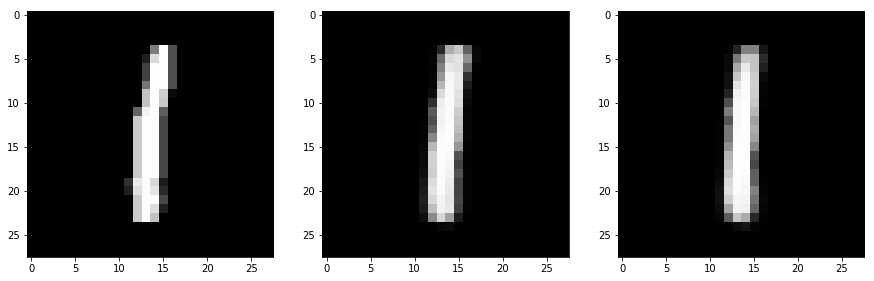

In [6]:
image, label = iter(MNIST_train).next()
with torch.no_grad():
    mu_z1, log_std_z1, mu_x1, log_std_x1, z1, x1 = MNIST_VAE1(image[0,:,:,:].view(-1), noise=False)
    mu_z2, log_std_z2, mu_x2, log_std_x2, z2, x2 = MNIST_VAE1(image[0,:,:,:].view(-1), noise=True)
x1 = x1.view(28,28)
x2 = x2.view(28,28)
plt.figure(figsize=(15,7.5))
plt.subplot(1,3,1)
plot_image(tensor=image[0,0,:,:], label=label[0])
plt.subplot(1,3,2)
plot_image(x1)
plt.subplot(1,3,3)
plot_image(x2)
plt.show()

## Test on gym, pong

In [7]:
import gym
env = gym.make('PongDeterministic-v4')

In [8]:
def process_image(state):
    graph = state.copy()
    graph = np.mean(graph, axis=2, keepdims=False)
    graph = graph[34:194,:]
    graph = np.where(graph==mode(graph, axis=None)[0].item(), 0, 1)
    return graph

In [9]:
n_episode = 30
max_t = 1000
t_max = 500
scores = []
recorder = []
for i in range(1, n_episode+1):
    state = env.reset()
    score = 0
    for t in range(max_t):
        recorder.append(process_image(state))
        action = np.random.randint(0,6)
        env.render()
        next_state, reward, done, _ = env.step(action)
        state = next_state
        score += reward
        if done:
            break 
    scores.append(score)

In [10]:
len(recorder)

26865

In [11]:
dataset = torch.stack([torch.tensor(image, dtype=torch.float32) for image in recorder])

In [12]:
dataset.size()

torch.Size([26865, 160, 160])

In [13]:
Pong_train = DataLoader(TensorDataset(dataset, torch.zeros((dataset.size(0), 1))), batch_size=128, shuffle=True)

In [14]:
Pong_VAE1 = VAE1(input_dim=160*160, code_dim=20, learning_rate=1e-3)
Pong_losses = Pong_VAE1.train(num_epoch = 10, trainloader=Pong_train)

Episode 1 batch group 100. Current average loss : 421.61145
Episode 1 batch group 200. Current average loss : 401.7343
Episode 1 batch group 210. Current average loss : 397.3952
Episode 2 batch group 100. Current average loss : 370.3159
Episode 2 batch group 200. Current average loss : 332.2101
Episode 2 batch group 210. Current average loss : 324.0155
Episode 3 batch group 100. Current average loss : 230.2783
Episode 3 batch group 200. Current average loss : 165.2853
Episode 3 batch group 210. Current average loss : 159.7938
Episode 4 batch group 100. Current average loss : 125.7207
Episode 4 batch group 200. Current average loss : 109.0150
Episode 4 batch group 210. Current average loss : 107.0340
Episode 5 batch group 100. Current average loss : 96.5336
Episode 5 batch group 200. Current average loss : 90.0889
Episode 5 batch group 210. Current average loss : 89.0262
Episode 6 batch group 100. Current average loss : 83.6437
Episode 6 batch group 200. Current average loss : 79.6485
E

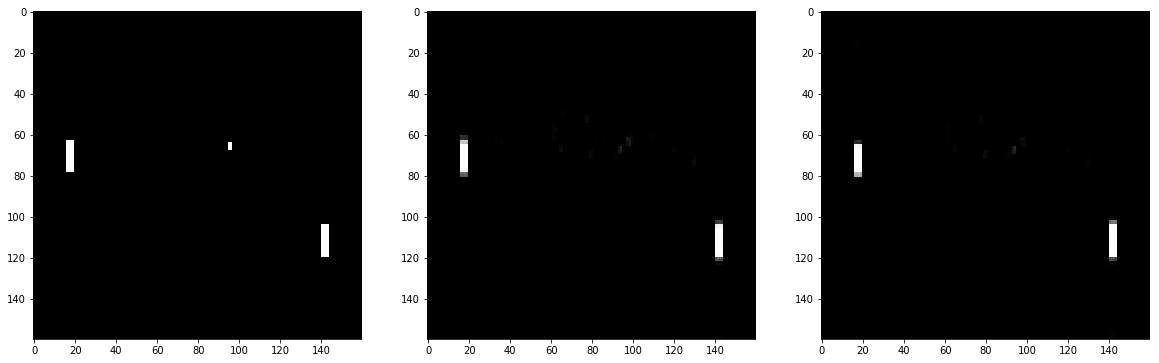

In [17]:
image, label = iter(Pong_train).next()
with torch.no_grad():
    mu_z1, log_std_z1, mu_x1, log_std_x1, z1, x1 = Pong_VAE1(image[0,:,:].view(-1), noise=False)
    mu_z2, log_std_z2, mu_x2, log_std_x2, z2, x2 = Pong_VAE1(image[0,:,:].view(-1), noise=True)
x1 = x1.view(160,160)
x2 = x2.view(160,160)
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plot_image(tensor=image[0,:,:])
plt.subplot(1,3,2)
plot_image(x1)
plt.subplot(1,3,3)
plot_image(x2)
plt.show()

In the above example we can see that VAE fails to recover the position with a ball: It only have a very dark mark on that position instead of a while point. But in the following example you can see that the ball is recovered.

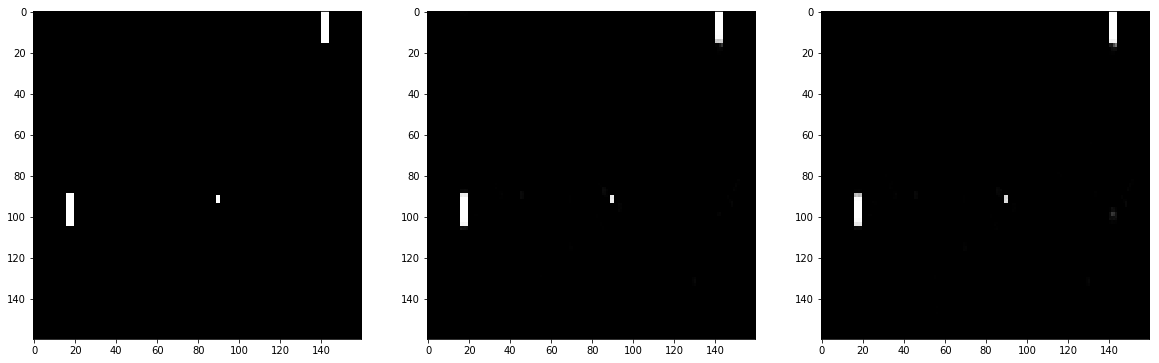

In [20]:
image, label = iter(Pong_train).next()
with torch.no_grad():
    mu_z1, log_std_z1, mu_x1, log_std_x1, z1, x1 = Pong_VAE1(image[0,:,:].view(-1), noise=False)
    mu_z2, log_std_z2, mu_x2, log_std_x2, z2, x2 = Pong_VAE1(image[0,:,:].view(-1), noise=True)
x1 = x1.view(160,160)
x2 = x2.view(160,160)
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plot_image(tensor=image[0,:,:])
plt.subplot(1,3,2)
plot_image(x1)
plt.subplot(1,3,3)
plot_image(x2)
plt.show()

In [ ]:
def train(agent, CNN=False, n_episode, max_t):
    score_window = deque(maxlen=100)
    all_score = []
    for i in range(1, n_episode+1):
        if CNN:
            previous_state = np.zeros(20)
        else
            previous_state = np.zeros((1, 160, 160))
        current_state = process_image(env.reset())
        episodic_score = 0
        if CNN:
            state = np.concatenate(previous_state, current_state)
        else:
            previous_state = previous_state.reshape(-1)
            with torch.no_grad():
                current_state, _, _, _, _, _ = Pong_VAE1(torch.tensor(current_state.reshape(1, -1), dtype=torch.float), noise=False)
                current_state = current_state.view(-1).numpy()
            state = np.concatenate(previous_state, current_state)
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = process_image(next_state)
            if CNN:
                next_state = np.concatenate(current_state, next_state)
            else:
                with torch.no_grad():
                    next_state, _, _, _, _, _ = Pong_VAE1(torch.tensor(next_state.reshape(1, -1), dtype=torch.float), noise=False)
                    next_state = next_state.view(-1).numpy()
                next_state = np.concatenate(current_state, next_state)
            agent.memory.add(state, action, reward, next_state, done)
            episodic_score += reward
            previous_state = current_state.copy()
            current_state = next_state[1].copy()
            if t % 4 ==0:
                if len(agent.memory)>agent.memory.batch_size:
                    experience = agent.memory.sample()
                    agent.learn(experience)
            if done:
                break
        score_window.append(episodic_score)
        all_score.append(episodic_score)
        print('\rEpisode {}\tEpisodic Score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, episodic_score, np.mean(scores_window),), end="")
        if i_episode % 100 == 0:
            print('')
        means.append(np.mean(scores_window))
            

In [ ]:
for i in range(1, n_episode+1):
    state = env.reset()
    score = 0
    for t in range(max_t):
        recoder.append(process_image(state))
        action = np.random.randint(0,6)
        env.render()
        next_state, reward, done, _ = env.step(action)
        state = next_state
        score += reward
        if done:
            break 
    scores.append(score)